In [1]:
import numpy as np

import torch
import torch.optim as optim

from models.regression import BayesianRegressor, BayesianRegressorHeteroscedastic
from utils.experiments import experiment
from utils.vis import visualize_training, weights_histogram, visualize_inference
from utils.predictive import mean_var_predictive


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creating Training Data

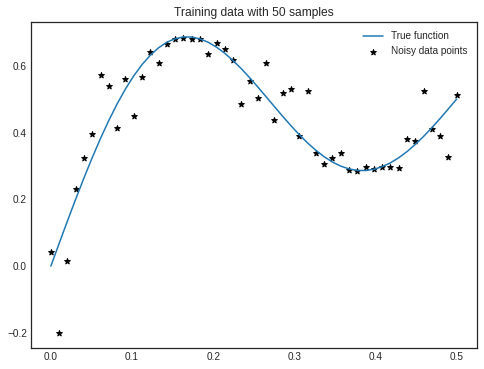

In [3]:
# toy dataset we can start with
train_samples = 50
x_train, y_train = experiment(xmin = 0.0, xmax = 0.5, samples = train_samples, std = 0.02)
_, y_train_true = experiment(xmin = 0.0, xmax = 0.5, samples = train_samples, std = 0)
# Visualizing data sample
_ = visualize_training(x_train.numpy(), y_train.numpy(), y_train_true.numpy())

## homoscedastic uncertainty
Defining model and training

In [4]:
ll_var = 0.05**2 # In the paper they always work with the stdv!
model = BayesianRegressor(hidden_dim=128, ll_var=ll_var, mixture_prior=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
elbo_samples = 6
epochs = 2000

x_train = x_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = model.energy_loss(x_train, y_train, elbo_samples)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 7018.1171875
epoch: 101/2000
Loss: 2820.0556640625
epoch: 201/2000
Loss: 2481.399658203125
epoch: 301/2000
Loss: 2197.8330078125
epoch: 401/2000
Loss: 1993.408203125
epoch: 501/2000
Loss: 1868.14697265625
epoch: 601/2000
Loss: 1874.44091796875
epoch: 701/2000
Loss: 1865.468505859375
epoch: 801/2000
Loss: 1740.0648193359375
epoch: 901/2000
Loss: 1653.14453125
epoch: 1001/2000
Loss: 1590.504150390625
epoch: 1101/2000
Loss: 1644.9599609375
epoch: 1201/2000
Loss: 1536.314697265625
epoch: 1301/2000
Loss: 1607.65625
epoch: 1401/2000
Loss: 1504.6239013671875
epoch: 1501/2000
Loss: 1507.822021484375
epoch: 1601/2000
Loss: 1433.237548828125
epoch: 1701/2000
Loss: 1430.494140625
epoch: 1801/2000
Loss: 1389.2994384765625
epoch: 1901/2000
Loss: 1364.2684326171875
Finished Training


Prediction

In [5]:
# samples is the number of "predictions" we make for 1 x-value.
test_samples = 500
exp_samples = 100
x_test, y_test = experiment(xmin = -0.2, xmax = 0.8, samples = test_samples, std = 0.02)
_, y_test_true = experiment(xmin = -0.2, xmax = 0.8, samples = test_samples, std = 0)
y_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
x_test = x_test.to(device)
for s in range(exp_samples):
    y_hat = model.forward(x_test).cpu().detach().numpy()
    y_samp[s, :] = y_hat.reshape(-1)

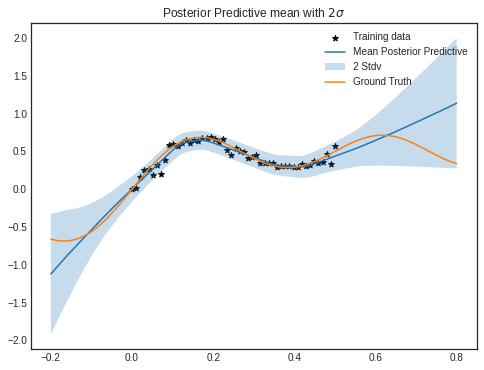

In [6]:
# Computing mean and variance of predictive distribution
predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
_ = visualize_inference(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                        x_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                        predictive_mean, predictive_var)


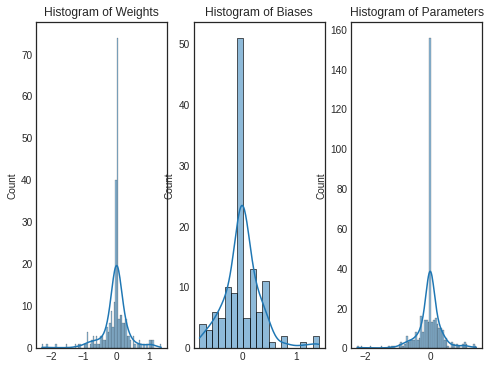

In [7]:
_, _ = weights_histogram(model)

## Heteroscedastic uncertainty
Defining model and training

In [23]:
ll_var = 1.0 # 0.05**2 # In the paper they always work with the stdv!
model = BayesianRegressorHeteroscedastic(hidden_dim=128, ll_var=ll_var, mixture_prior=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
elbo_samples = 6
epochs = 2000

x_train = x_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    if epoch > 1000: # Start variance estimation
        loss = model.energy_loss(x_train, y_train, elbo_samples, False)
    else:
        loss = model.energy_loss(x_train, y_train, elbo_samples, True)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 140485.53125
epoch: 101/2000
Loss: 138846.34375
epoch: 201/2000
Loss: 137084.21875
epoch: 301/2000
Loss: 135384.328125
epoch: 401/2000
Loss: 133762.125
epoch: 501/2000
Loss: 132024.65625
epoch: 601/2000
Loss: 130320.6328125
epoch: 701/2000
Loss: 128674.3359375
epoch: 801/2000
Loss: 126878.2734375
epoch: 901/2000
Loss: 125250.671875
epoch: 1001/2000
Loss: 123576.015625
epoch: 1101/2000
Loss: 121855.53125
epoch: 1201/2000
Loss: 120074.53125
epoch: 1301/2000
Loss: 118394.6328125
epoch: 1401/2000
Loss: 116742.8984375
epoch: 1501/2000
Loss: 115060.125
epoch: 1601/2000
Loss: 113391.8515625
epoch: 1701/2000
Loss: 111740.890625
epoch: 1801/2000
Loss: 110058.15625
epoch: 1901/2000
Loss: 108331.046875
Finished Training


Prediction

In [24]:
# samples is the number of "predictions" we make for 1 x-value.
test_samples = 500
exp_samples = 100
x_test, y_test = experiment(xmin = 0.0, xmax = 0.5, samples = test_samples, std = 0.02)
_, y_test_true = experiment(xmin = 0.0, xmax = 0.5, samples = test_samples, std = 0)
y_samp = np.zeros((exp_samples, test_samples))
var_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
x_test = x_test.to(device)
for s in range(exp_samples):
    y_hat = model.forward(x_test).cpu().detach().numpy()
    y_samp[s, :] = y_hat[:,0].reshape(-1)
    # Exponentiate and recover variance
    var_samp[s, :] = np.exp(y_hat[:,1].reshape(-1))

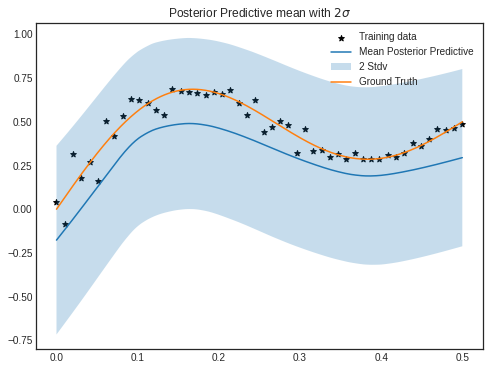

In [25]:
# Computing mean and variance of predictive distribution
predictive_mean, predictive_var = mean_var_predictive(y_samp, var_samp)
_ = visualize_inference(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                        x_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                        predictive_mean, predictive_var)


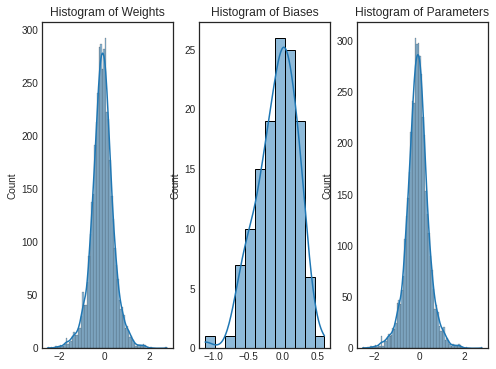

In [22]:
_, _ = weights_histogram(model)